In [119]:
!pip install tensorflow keras

In [120]:
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
from IPython.display import Image
import plotly.graph_objects as go
from keras.utils import plot_model
from keras.models import Sequential
from IPython.display import Image, display
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout

In [121]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/1VNIndex.xlsx' # Đường dẫn đã được cập nhật
df = pd.read_excel(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [123]:
df.head()


,Price
Date,
2000-07-31,101.55
2000-08-02,103.38
2000-08-04,105.20
2000-08-07,106.92
2000-08-09,108.64


In [124]:
return_series=np.log(df['Price']/df['Price'].shift(1))

In [125]:
return_series = return_series.dropna()

In [126]:
return_series

,Price
Date,
2000-08-02,0.017860
2000-08-04,0.017452
2000-08-07,0.016218
2000-08-09,0.015959
2000-08-11,0.015708
...,...
2024-12-10,-0.001390
2024-12-11,-0.002527
2024-12-12,-0.001191


In [127]:
r_t=return_series.values.reshape(5931,1)

In [128]:
# prompt: đưa ra bảng mô tả thống kê, kurtosis, jacque cho r_t

import pandas as pd
import numpy as np

# Assuming 'return_series' and 'r_t' are defined as in the previous code
# ... (your existing code) ...

# Calculate descriptive statistics
r_t_series = pd.Series(r_t.flatten()) # Convert r_t to a pandas Series for easier calculations
description = r_t_series.describe()

# Calculate kurtosis and skewness (Fisher's definition)
kurtosis = r_t_series.kurtosis()
skewness = r_t_series.skew()


# Print the results
print("Descriptive Statistics:")
print(description)
print("\nKurtosis:", kurtosis)
print("\nSkewness (Fisher):", skewness)

# Create a summary table
summary_table = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Standard Deviation', 'Min', '25%', '50%', '75%', 'Max', 'Kurtosis', 'Skewness'],
    'Value': [description['count'], description['mean'], description['std'], description['min'], description['25%'],
              description['50%'], description['75%'], description['max'], kurtosis, skewness]
})

print("\nSummary Table:")
summary_table

Descriptive Statistics:
count    5931.000000
mean        0.000425
std         0.014439
min        -0.076557
25%        -0.005534
50%         0.000607
75%         0.007378
max         0.066561
dtype: float64

Kurtosis: 3.4097427278606807

Skewness (Fisher): -0.3953987594767815

Summary Table:


,Statistic,Value
0,Count,5931.000000
1,Mean,0.000425
2,Standard Deviation,0.014439
3,Min,-0.076557
4,25%,-0.005534
5,50%,0.000607
6,75%,0.007378
7,Max,0.066561
8,Kurtosis,3.409743
9,Skewness,-0.395399


In [129]:
# prompt: đưa ra kết quả jacque bera test cho r_t

import numpy as np
import pandas as pd
from scipy.stats import jarque_bera

# Assuming 'r_t' is defined as in the previous code
# ... (your existing code) ...

# Perform Jarque-Bera test
jb_statistic, p_value = jarque_bera(r_t.flatten())

print("\nJarque-Bera Test:")
print("Statistic:", jb_statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: The data does not follow a normal distribution.")
else:
    print("Fail to reject the null hypothesis: The data may follow a normal distribution.")


Jarque-Bera Test:
Statistic: 3021.0807048199413
p-value: 0.0
Reject the null hypothesis: The data does not follow a normal distribution.


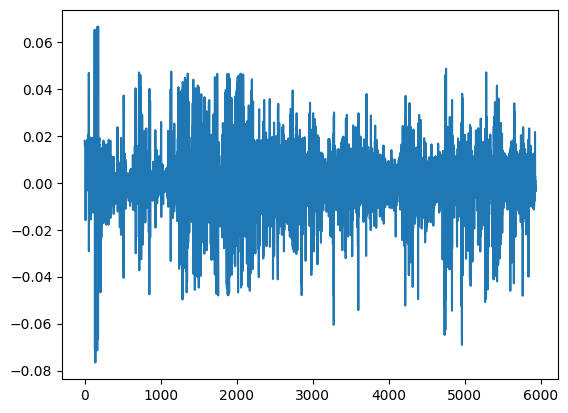

In [130]:
from matplotlib import pyplot as plt
plt.plot(r_t)
plt.show()

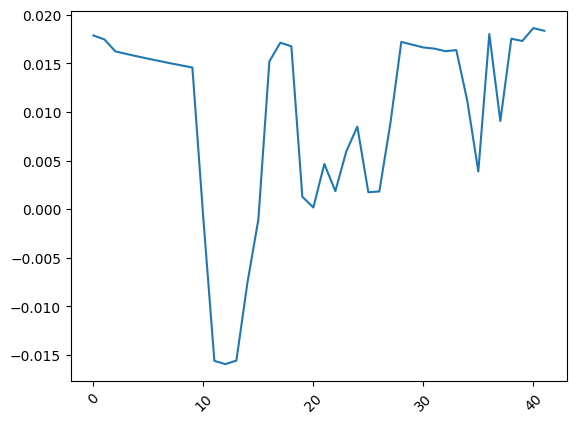

In [131]:
plt.plot(r_t[:42])
plt.xticks(rotation=45)
plt.show()

In [132]:
# prompt: Kiểm tra tính dừng r_t bằng các kiểm định như ADF test

!pip install statsmodels

from statsmodels.tsa.stattools import adfuller

# Assuming 'r_t' is defined as in the previous code
# ... (your existing code) ...

# Perform ADF test
result = adfuller(np.array(r_t).flatten())

print('\nAugmented Dickey-Fuller Test:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis: The time series is stationary.")
else:
    print("Fail to reject the null hypothesis: The time series is non-stationary.")


Augmented Dickey-Fuller Test:
ADF Statistic: -17.089139
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis: The time series is stationary.


In [133]:
seq_len = 11
sequence = []
for index in range(len(r_t) - seq_len + 1):
    sequence.append(r_t[index: index + seq_len])
sequence = np.array(sequence)
print(sequence.shape)


(5921, 11, 1)


In [134]:
def split_data(sequence):
    train_data, test_data = train_test_split(sequence, test_size=0.3, shuffle=False,random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False,random_state=42)
    return train_data, val_data, test_data

In [135]:

train_data, val_data, test_data = split_data(sequence)
print("Train:", train_data.shape, "Validation:", val_data.shape, "Test:", test_data.shape)

Train: (4144, 11, 1) Validation: (888, 11, 1) Test: (889, 11, 1)


In [136]:
# Concatenate train_data and val_data
combined_train_data = np.concatenate((train_data, val_data), axis=0)

print("Combined Train Data shape:", combined_train_data.shape)


Combined Train Data shape: (5032, 11, 1)


In [137]:

x_train = combined_train_data[:, :-1, :]
y_train = combined_train_data[:, -1, -1]
y_train2=y_train*100


x_test = test_data[:, :-1, :]
y_test = test_data[:, -1, -1]

# Kiểm tra kích thước của các tập dữ liệu
print(f"x_train shape: {x_train.shape}")  # (samples, timesteps * features)
print(f"y_train shape: {y_train.shape}")  # (samples,)
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (5032, 10, 1)
y_train shape: (5032,)
x_test shape: (889, 10, 1)
y_test shape: (889,)


In [138]:
!pip install arch

In [139]:
import arch
import pandas as pd
import numpy as np

In [140]:
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# Parameter ranges
m_values = range(1, 4)  # AR orders
n_values = range(1, 4)  # MA orders
p_values = range(1, 4)  # GARCH orders
q_values = range(1, 4)  # ARCH orders

best_model = None
best_bic = float('inf')

for m in m_values:
    for n in n_values:
        for p in p_values:
            for q in q_values:
                try:
                    # Fit ARMA model
                    arma_model = ARIMA(y_train2, order=(m, 0, n)).fit()

                    # Fit GARCH model to ARMA residuals
                    residuals = arma_model.resid
                    garch_model = arch_model(residuals, vol='Garch', p=p, q=q, dist='normal').fit(disp="off")

                    # Calculate BIC
                    bic = garch_model.bic
                    print(f"ARMA({m}, {n}) - GARCH({p}, {q}) | BIC: {bic}")

                    # Update best model if BIC is lower
                    if bic < best_bic:
                        best_bic = bic
                        best_model = (arma_model, garch_model)
                        best_params = (m, n, p, q)
                except Exception as e:
                    continue  # Skip invalid parameter combinations

# Output the best model and parameters
print(f"Best Parameters: ARMA({best_params[0]}, {best_params[1]}) - GARCH({best_params[2]}, {best_params[3]})")
print(f"Minimum BIC: {best_bic}")




ARMA(1, 1) - GARCH(1, 1) | BIC: 15562.043927665372
ARMA(1, 1) - GARCH(1, 2) | BIC: 15565.959176472155
ARMA(1, 1) - GARCH(1, 3) | BIC: 15564.076286619236
ARMA(1, 1) - GARCH(2, 1) | BIC: 15570.567500472029
ARMA(1, 1) - GARCH(2, 2) | BIC: 15574.482749250312
ARMA(1, 1) - GARCH(2, 3) | BIC: 15571.931067900921
ARMA(1, 1) - GARCH(3, 1) | BIC: 15579.091073352736
ARMA(1, 1) - GARCH(3, 2) | BIC: 15583.006321860248
ARMA(1, 1) - GARCH(3, 3) | BIC: 15580.454641796596
ARMA(1, 2) - GARCH(1, 1) | BIC: 15551.257542162242
ARMA(1, 2) - GARCH(1, 2) | BIC: 15554.985273373695
ARMA(1, 2) - GARCH(1, 3) | BIC: 15552.940144763295
ARMA(1, 2) - GARCH(2, 1) | BIC: 15559.78111494871
ARMA(1, 2) - GARCH(2, 2) | BIC: 15563.508848949556
ARMA(1, 2) - GARCH(2, 3) | BIC: 15560.85541166336
ARMA(1, 2) - GARCH(3, 1) | BIC: 15568.304687823163
ARMA(1, 2) - GARCH(3, 2) | BIC: 15572.03247375603
ARMA(1, 2) - GARCH(3, 3) | BIC: 15569.378980441996
ARMA(1, 3) - GARCH(1, 1) | BIC: 15552.073674831545
ARMA(1, 3) - GARCH(1, 2) | BIC: 15

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 2) - GARCH(1, 1) | BIC: 15566.485844538945


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 2) - GARCH(1, 2) | BIC: 15570.402779747088


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 2) - GARCH(1, 3) | BIC: 15568.620949398699


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 2) - GARCH(2, 1) | BIC: 15575.009417805712


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 2) - GARCH(2, 2) | BIC: 15578.926352671411


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 2) - GARCH(2, 3) | BIC: 15576.503952431542


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 2) - GARCH(3, 1) | BIC: 15583.53299006364


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 2) - GARCH(3, 2) | BIC: 15587.44992529985


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 2) - GARCH(3, 3) | BIC: 15585.027525442345
ARMA(2, 3) - GARCH(1, 1) | BIC: 15554.841154091926
ARMA(2, 3) - GARCH(1, 2) | BIC: 15558.720565919397
ARMA(2, 3) - GARCH(1, 3) | BIC: 15556.31434903736
ARMA(2, 3) - GARCH(2, 1) | BIC: 15563.364727037177
ARMA(2, 3) - GARCH(2, 2) | BIC: 15567.244903695815
ARMA(2, 3) - GARCH(2, 3) | BIC: 15564.02162296022
ARMA(2, 3) - GARCH(3, 1) | BIC: 15571.88830353844
ARMA(2, 3) - GARCH(3, 2) | BIC: 15575.767710901455
ARMA(2, 3) - GARCH(3, 3) | BIC: 15572.545189469312
ARMA(3, 1) - GARCH(1, 1) | BIC: 15564.614702026174
ARMA(3, 1) - GARCH(1, 2) | BIC: 15568.533661623751
ARMA(3, 1) - GARCH(1, 3) | BIC: 15566.651294601657
ARMA(3, 1) - GARCH(2, 1) | BIC: 15573.138274707213
ARMA(3, 1) - GARCH(2, 2) | BIC: 15577.057234558828
ARMA(3, 1) - GARCH(2, 3) | BIC: 15574.50214122299
ARMA(3, 1) - GARCH(3, 1) | BIC: 15581.661847635261
ARMA(3, 1) - GARCH(3, 2) | BIC: 15585.58080767109
ARMA(3, 1) - GARCH(3, 3) | BIC: 15583.025713881336


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3, 2) - GARCH(1, 1) | BIC: 15559.838542542842


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3, 2) - GARCH(1, 2) | BIC: 15563.969350965637


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3, 2) - GARCH(1, 3) | BIC: 15562.502227449395


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3, 2) - GARCH(2, 1) | BIC: 15568.362115285863


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3, 2) - GARCH(2, 2) | BIC: 15572.492923322514


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3, 2) - GARCH(2, 3) | BIC: 15570.322432883313


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3, 2) - GARCH(3, 1) | BIC: 15576.885688061158


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3, 2) - GARCH(3, 2) | BIC: 15581.016496051263


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3, 2) - GARCH(3, 3) | BIC: 15578.846000024614
ARMA(3, 3) - GARCH(1, 1) | BIC: 15565.974095134397
ARMA(3, 3) - GARCH(1, 2) | BIC: 15569.338843010655
ARMA(3, 3) - GARCH(1, 3) | BIC: 15567.116799717425
ARMA(3, 3) - GARCH(2, 1) | BIC: 15574.497672149615
ARMA(3, 3) - GARCH(2, 2) | BIC: 15577.86241696879
ARMA(3, 3) - GARCH(2, 3) | BIC: 15575.238859772791
ARMA(3, 3) - GARCH(3, 1) | BIC: 15583.021243001635
ARMA(3, 3) - GARCH(3, 2) | BIC: 15586.38598835158
ARMA(3, 3) - GARCH(3, 3) | BIC: 15583.762426163348
Best Parameters: ARMA(1, 2) - GARCH(1, 1)
Minimum BIC: 15551.257542162242


In [141]:
# Output the best model summary
arma_model, garch_model = best_model
print(arma_model.summary())
print("\nGARCH Model Summary:")

print(garch_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5032
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -8922.490
Date:                Tue, 31 Dec 2024   AIC                          17854.980
Time:                        11:28:21   BIC                          17887.598
Sample:                             0   HQIC                         17866.408
                               - 5032                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0485      0.043      1.133      0.257      -0.035       0.132
ar.L1          0.9430      0.012     79.935      0.000       0.920       0.966
ma.L1         -0.6906      0.014    -48.763      0.0

In [142]:
arma_pred = arma_model.predict(start=len(y_train2), end=len(y_train2) + len(y_test) - 1)

# Dự đoán sự biến động từ GARCH (conditional volatility)
garch_volatility = garch_model.conditional_volatility

# Kết hợp dự đoán ARMA và GARCH để có dự đoán cuối cùng
# Dự đoán cuối cùng sẽ là giá trị ARMA cộng với sự biến động từ GARCH
final_pred = arma_pred + garch_volatility[:len(arma_pred)]

predictions=final_pred/100
predictions

array([0.01259616, 0.01141719, 0.01287246, 0.01311313, 0.013235  ,
       0.01221849, 0.01124419, 0.01297459, 0.01367008, 0.01403549,
       0.01284899, 0.01175881, 0.01096778, 0.01010288, 0.00965975,
       0.00946573, 0.00879162, 0.00821015, 0.00847771, 0.0103512 ,
       0.0110477 , 0.01150823, 0.01175972, 0.01184836, 0.01189626,
       0.01114416, 0.01024361, 0.011583  , 0.01065453, 0.01150841,
       0.01154003, 0.01189494, 0.01198736, 0.0119999 , 0.01192361,
       0.01179196, 0.01162097, 0.0120935 , 0.01190752, 0.0108972 ,
       0.01073762, 0.01230032, 0.01216616, 0.01216649, 0.01204565,
       0.0118862 , 0.02069711, 0.02724105, 0.02630487, 0.02399208,
       0.02228492, 0.02066013, 0.01923503, 0.01749265, 0.01697278,
       0.01591583, 0.01509466, 0.01434981, 0.01382532, 0.01300426,
       0.01199031, 0.01219434, 0.0119373 , 0.01180795, 0.01164628,
       0.01145071, 0.01144506, 0.01149529, 0.01115479, 0.01358042,
       0.01439529, 0.01439067, 0.01420367, 0.01300087, 0.01363

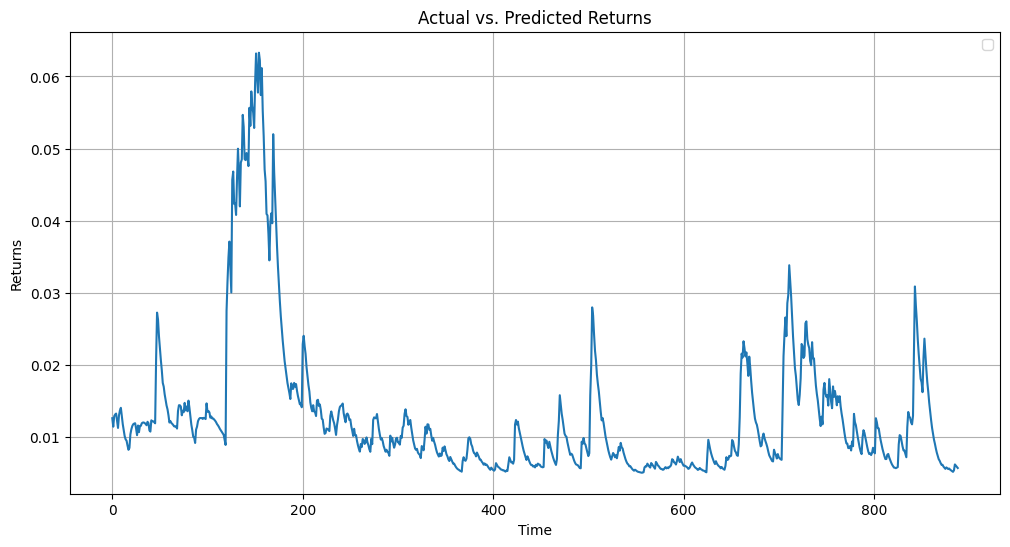

In [143]:
# prompt: vẽ biểu đồ predictions

import matplotlib.pyplot as plt

# Assuming 'predictions' and 'y_test' are defined as in the previous code
# ... (your existing code) ...

# Create the plot
plt.figure(figsize=(12, 6))

plt.plot(predictions)
# Add labels and title
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Actual vs. Predicted Returns')
plt.legend()
plt.grid(True)
plt.show()

In [144]:
import tensorflow as tf
r_t_test = tf.cast(y_test, dtype=tf.float32)  # Ép kiểu y_true về tf.float32
sigma_t = tf.cast(predictions, dtype=tf.float32) # Cast y_pred to tf.float32 as well
# Constants
import math
pi=math.pi

log_L = np.sum(-0.5 * np.log(2 *pi) - np.log(sigma_t) - (r_t_test**2) / (2 * sigma_t**2))
log_L

2279.0466